In [1]:
import pandas as pd
import numpy as np
from helpers import *
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sklearn.cluster import KMeans

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Load in Datasets, turn all columns to uppercase and concatenate the two dataframes from 2014 and 2016 together

In [2]:
pam16_df=pd.read_sas("PAM/hn16_pam.sas7bdat")
all16_df=pd.read_sas("ALL/hn16_all.sas7bdat")
pam14_df=pd.read_sas("PAM/HN14_PAM.sas7bdat")
all14_df=pd.read_sas("ALL/hn14_all.sas7bdat")

func = lambda df: df.rename(columns=str.upper)
pam14_df, pam16_df, all14_df, all16_df = map(func, [pam14_df, pam16_df, all14_df, all16_df])
pam_combined = pd.concat([pam14_df, pam16_df], ignore_index=True)
all_combined = pd.concat([all14_df, all16_df], ignore_index=True)
pam_combined.drop('MOD_D', axis=1, inplace=True)
pam_combined['ID'] = pam_combined['ID'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
all_combined['ID'] = all_combined['ID'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
all14_df['ID'] = all14_df['ID'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
all16_df['ID'] = all16_df['ID'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

In [3]:
print(len(all16_df.columns), len(all14_df.columns), len(all_combined.columns), len(pam16_df.columns), len(pam14_df.columns), len(pam_combined.columns))

804 746 895 12 12 11


These Columns can be used for EDA

In [4]:
all_combined = all_combined[["ID", "YEAR", "SEX", "AGE", 'BP_PHQ_1', 'BP_PHQ_2', 'BP_PHQ_3', 'BP_PHQ_4', 'BP_PHQ_5', 'BP_PHQ_6', 'BP_PHQ_7', 'BP_PHQ_8',"BP_PHQ_9",
                  "MH_PHQ_S", "HE_BMI", "MH_STRESS", "EQ5D"]]
all14_df = all14_df[["ID", "YEAR", "SEX", "AGE", 'BP_PHQ_1', 'BP_PHQ_2', 'BP_PHQ_3', 'BP_PHQ_4', 'BP_PHQ_5', 'BP_PHQ_6', 'BP_PHQ_7', 'BP_PHQ_8',"BP_PHQ_9",
                  "MH_PHQ_S", "HE_BMI", "MH_STRESS", "EQ5D"]]
all16_df = all16_df[["ID", "YEAR", "SEX", "AGE", 'BP_PHQ_1', 'BP_PHQ_2', 'BP_PHQ_3', 'BP_PHQ_4', 'BP_PHQ_5', 'BP_PHQ_6', 'BP_PHQ_7', 'BP_PHQ_8',"BP_PHQ_9",
                  "MH_PHQ_S", "HE_BMI", "MH_STRESS", "EQ5D"]]

Print length of the columns

In [5]:
print(len(all16_df.columns), len(all14_df.columns), len(all_combined.columns), len(pam16_df.columns), len(pam14_df.columns), len(pam_combined.columns))

17 17 17 12 12 11


Do EDA on the two Datasets that include
- Plot the correlation between features with the Assessment
- When are the patients most active
- Do EDA for each year 
- combat NaN values with different methods
- How do sex, age, bmi and stress correlate with the BP_PHQ Questions (When you are overweight do you have a higher score?)
- What is EQ5D and how is it correlated with depression

Get the number of NaN Values in each dataset and get the statistical measure of each column

In [6]:
print("Number of NaN values in Dataset " + f"{all14_df.isnull().sum().sum()}")
print(all14_df.describe())

Number of NaN values in Dataset 13349
         YEAR          SEX          AGE     BP_PHQ_1     BP_PHQ_2  \
count  7550.0  7550.000000  7550.000000  6891.000000  6891.000000   
mean   2014.0     1.551656    42.450728     2.549412     2.508199   
std       0.0     0.497357    23.002748     3.580951     3.600723   
min    2014.0     1.000000     1.000000     0.000000     0.000000   
25%    2014.0     1.000000    23.000000     0.000000     0.000000   
50%    2014.0     2.000000    44.000000     0.000000     0.000000   
75%    2014.0     2.000000    61.000000     8.000000     8.000000   
max    2014.0     2.000000    80.000000     9.000000     9.000000   

          BP_PHQ_3     BP_PHQ_4     BP_PHQ_5     BP_PHQ_6     BP_PHQ_7  \
count  6891.000000  6891.000000  6891.000000  6891.000000  6891.000000   
mean      2.709766     2.799013     2.518357     2.462632     2.390509   
std       3.522302     3.473487     3.610548     3.635200     3.657708   
min       0.000000     0.000000     0.000000

In [7]:
print("Number of NaN values in Dataset " + f"{all16_df.isnull().sum().sum()}")
print(all16_df.describe())

Number of NaN values in Dataset 9851
         YEAR          SEX          AGE     BP_PHQ_1     BP_PHQ_2  \
count  8150.0  8150.000000  8150.000000  7797.000000  7797.000000   
mean   2016.0     1.550307    41.811656     2.373862     2.306785   
std       0.0     0.497493    22.982303     3.476617     3.499142   
min    2016.0     1.000000     1.000000     0.000000     0.000000   
25%    2016.0     1.000000    23.000000     0.000000     0.000000   
50%    2016.0     2.000000    43.000000     0.000000     0.000000   
75%    2016.0     2.000000    61.000000     8.000000     8.000000   
max    2016.0     2.000000    80.000000     9.000000     9.000000   

          BP_PHQ_3     BP_PHQ_4     BP_PHQ_5     BP_PHQ_6     BP_PHQ_7  \
count  7797.000000  7797.000000  7797.000000  7797.000000  7797.000000   
mean      2.534436     2.610363     2.325766     2.240605     2.198923   
std       3.414949     3.382308     3.490781     3.523334     3.542284   
min       0.000000     0.000000     0.000000 

In [8]:
print("Number of NaN values in Dataset " + f"{pam14_df.isnull().sum().sum()}")
print(pam14_df.describe())

Number of NaN values in Dataset 0
            YEAR           SEX           AGE        DAY     PAXDAY  \
count  9848160.0  9.848160e+06  9.848160e+06  9848160.0  9848160.0   
mean      2014.0  1.611054e+00  4.246059e+01        4.0        4.0   
std          0.0  4.875110e-01  1.319365e+01        2.0        2.0   
min       2014.0  1.000000e+00  1.900000e+01        1.0        1.0   
25%       2014.0  1.000000e+00  3.200000e+01        2.0        2.0   
50%       2014.0  2.000000e+00  4.300000e+01        4.0        4.0   
75%       2014.0  2.000000e+00  5.400000e+01        6.0        6.0   
max       2014.0  2.000000e+00  6.500000e+01        7.0        7.0   

               PAXN       PAXHOUR      PAXMINUT      PAXINTEN       PAXSTEP  
count  9.848160e+06  9.848160e+06  9.848160e+06  9.848160e+06  9.848160e+06  
mean   5.040500e+03  1.150000e+01  2.950000e+01  1.706878e+02  4.905595e+00  
std    2.909845e+03  6.922187e+00  1.731810e+01  5.422289e+02  1.638859e+01  
min    1.000000e+00  0.

In [9]:
print("Number of NaN values in Dataset " + f"{pam16_df.isnull().sum().sum()}")
print(pam16_df.describe())

Number of NaN values in Dataset 0
            YEAR           SEX           AGE        DAY     PAXDAY  \
count  5796000.0  5.796000e+06  5.796000e+06  5796000.0  5796000.0   
mean      2016.0  1.629565e+00  4.072000e+01        4.0        4.0   
std          0.0  4.829212e-01  1.282863e+01        2.0        2.0   
min       2016.0  1.000000e+00  1.900000e+01        1.0        1.0   
25%       2016.0  1.000000e+00  3.000000e+01        2.0        2.0   
50%       2016.0  2.000000e+00  4.100000e+01        4.0        4.0   
75%       2016.0  2.000000e+00  5.100000e+01        6.0        6.0   
max       2016.0  2.000000e+00  6.400000e+01        7.0        7.0   

               PAXN       PAXHOUR      PAXMINUT      PAXINTEN       PAXSTEP  
count  5.796000e+06  5.796000e+06  5.796000e+06  5.796000e+06  5.796000e+06  
mean   5.040500e+03  1.150000e+01  2.950000e+01  1.555506e+02  4.184478e+00  
std    2.909846e+03  6.922187e+00  1.731810e+01  4.969232e+02  1.480958e+01  
min    1.000000e+00  0.

Fill in the NaN Values in the all Datasets to further explore the data

In [10]:
all14_df, all16_df = process_data(all14_df), process_data(all16_df)

The BP_PHQ Assement Questions all have the nearly same mean and value distribution so they will be plotted together in the same plot with features sex, bmi, age, mh_stress and EQ5D

In [11]:
print("Unique values in the dataframes --->")
for i in range(9):
    print(f"BP_PHQ_{i+1} Values:")
    print(all16_df[f"BP_PHQ_{i+1}"].unique())
    print(all14_df[f"BP_PHQ_{i+1}"].unique())
print(f"MH_PHQ_S Values:")
print(all16_df["MH_PHQ_S"].unique())
print(all14_df["MH_PHQ_S"].unique())

Unique values in the dataframes --->
BP_PHQ_1 Values:
[0. 1. 8. 2. 3. 9.]
[0. 2. 8. 1. 3. 9.]
BP_PHQ_2 Values:
[0. 1. 8. 2. 3. 9.]
[0. 1. 2. 8. 3. 9.]
BP_PHQ_3 Values:
[0. 1. 8. 2. 3. 9.]
[1. 0. 2. 8. 3. 9.]
BP_PHQ_4 Values:
[0. 1. 8. 2. 3. 9.]
[0. 1. 2. 8. 3. 9.]
BP_PHQ_5 Values:
[0. 8. 1. 2. 3. 9.]
[0. 1. 2. 8. 3. 9.]
BP_PHQ_6 Values:
[0. 1. 8. 2. 3. 9.]
[0. 3. 1. 2. 8. 9.]
BP_PHQ_7 Values:
[0. 8. 1. 2. 3. 9.]
[0. 2. 8. 3. 1. 9.]
BP_PHQ_8 Values:
[0. 1. 8. 2. 9. 3.]
[0. 2. 8. 1. 3. 9.]
BP_PHQ_9 Values:
[0. 1. 8. 2. 9. 3.]
[0. 1. 2. 8. 3. 9.]
MH_PHQ_S Values:
[ 0.  5.  2.  1.  3.  4.  6.  7. 19.  9.  8. 13. 12. 18. 11. 15. 10. 23.
 14. 24. 17. 16. 20. 21. 22. 27.]
[ 1.  7.  0.  3.  2.  9.  8.  4.  6. 17. 20.  5. 12. 11. 16. 10. 22. 14.
 18. 15. 13. 19. 21. 27. 24. 23. 25.]


Check for correlations between the different features

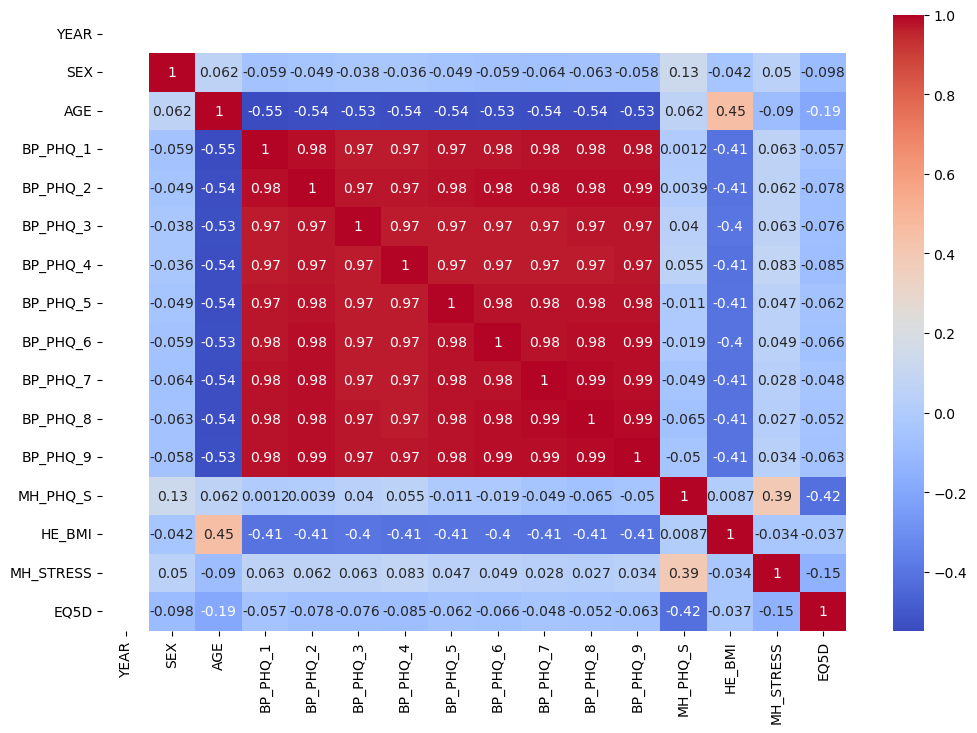

In [12]:
# Correlation matrix
correlation_matrix = all14_df[["YEAR", "SEX", "AGE", 'BP_PHQ_1', 'BP_PHQ_2', 'BP_PHQ_3', 'BP_PHQ_4', 'BP_PHQ_5', 'BP_PHQ_6', 'BP_PHQ_7', 'BP_PHQ_8',"BP_PHQ_9",
                  "MH_PHQ_S", "HE_BMI", "MH_STRESS", "EQ5D"]].corr(method='pearson')

# Heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

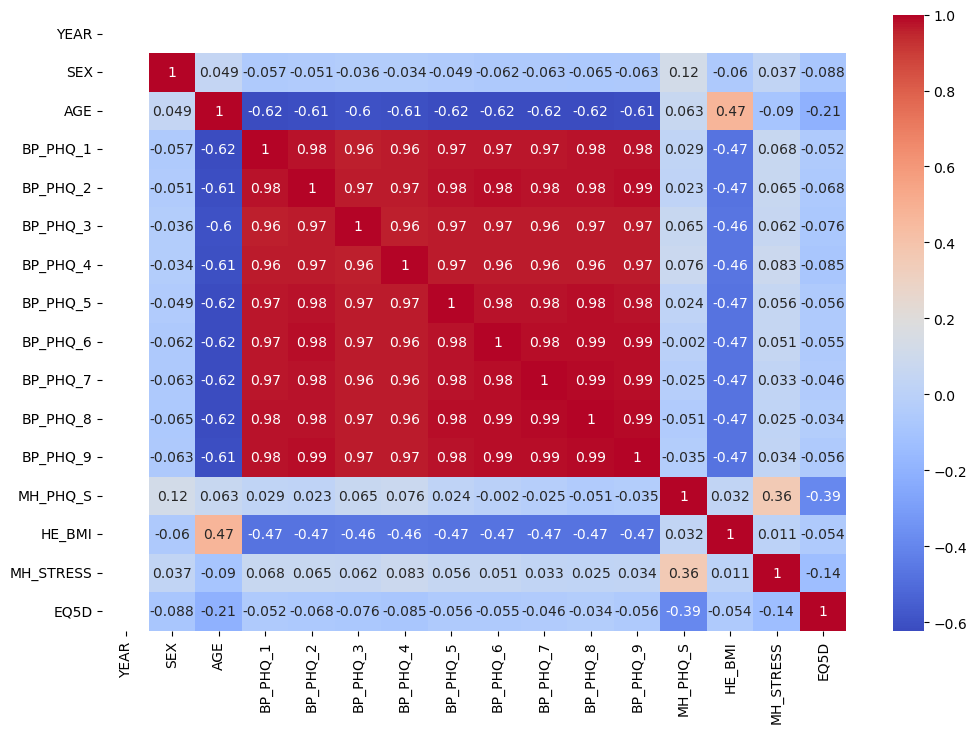

In [13]:
# Correlation matrix
correlation_matrix = all16_df[["YEAR", "SEX", "AGE", 'BP_PHQ_1', 'BP_PHQ_2', 'BP_PHQ_3', 'BP_PHQ_4', 'BP_PHQ_5', 'BP_PHQ_6', 'BP_PHQ_7', 'BP_PHQ_8',"BP_PHQ_9",
                  "MH_PHQ_S", "HE_BMI", "MH_STRESS", "EQ5D"]].corr(method='pearson')

# Heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Things to take away from the confusion matrix
- BMI increases -> age increases and bps decrease
- Stress increases -> mh_phq_s increases
- EQ5D increases -> mh_phq_s decreases
- age increases -> bp_phq decreases
- one weird thing is that the depression levels have a negative correlation with the bmi

Now plot the different features (age, bmi, EQ5D, sex) based on the assessment scores

Plot the distribution of the different depression scores from year 2014

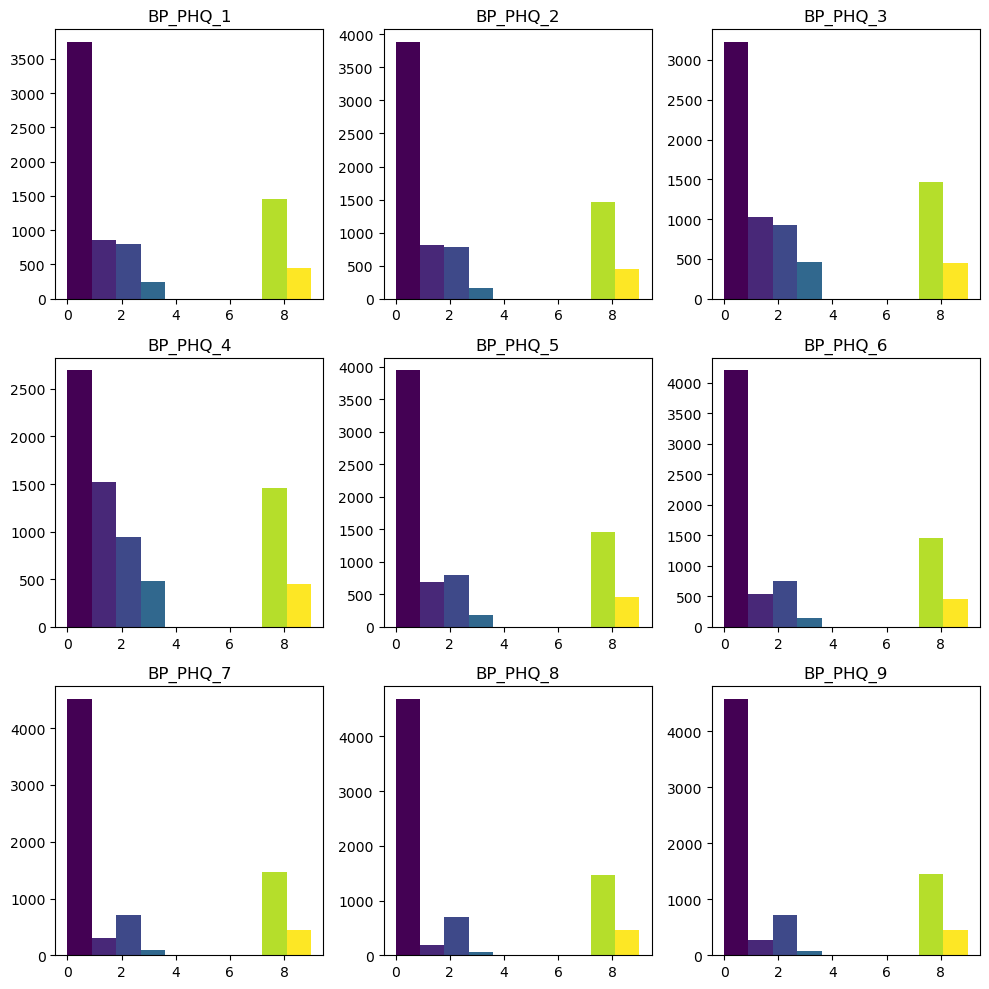

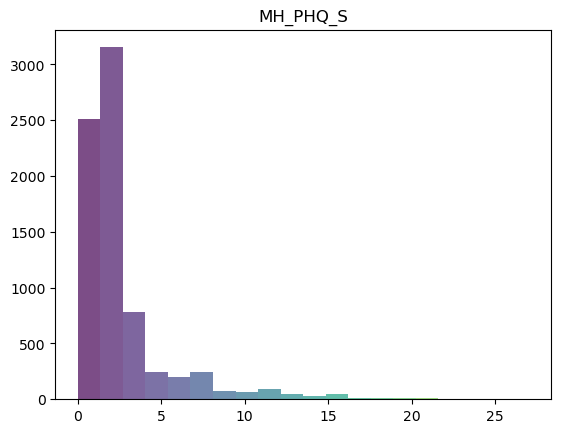

In [14]:
fig, axs = plt.subplots(3, 3 , figsize=(10, 10))
number = 1

for i in range(3):
    for j in range(3):
        n,bins, patches = axs[i, j].hist(all14_df[f"BP_PHQ_{number}"])
        axs[i, j].set_title(f"BP_PHQ_{number}")
        colors = plt.cm.viridis(np.linspace(0, 1, len(patches)))
        # Color each bin differently
        for patch, color in zip(patches, colors):
            patch.set_facecolor(color)

        number += 1
plt.tight_layout()
plt.show()

n,bins, patches = plt.hist(all14_df["MH_PHQ_S"], bins=20, color='blue', alpha=0.7, label="ALL16")

plt.title("MH_PHQ_S")
# Define colors
colors = plt.cm.viridis(np.linspace(0, 1, len(patches)))

for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

plt.show()

Plot the distribution of the different depression scores from year 2016

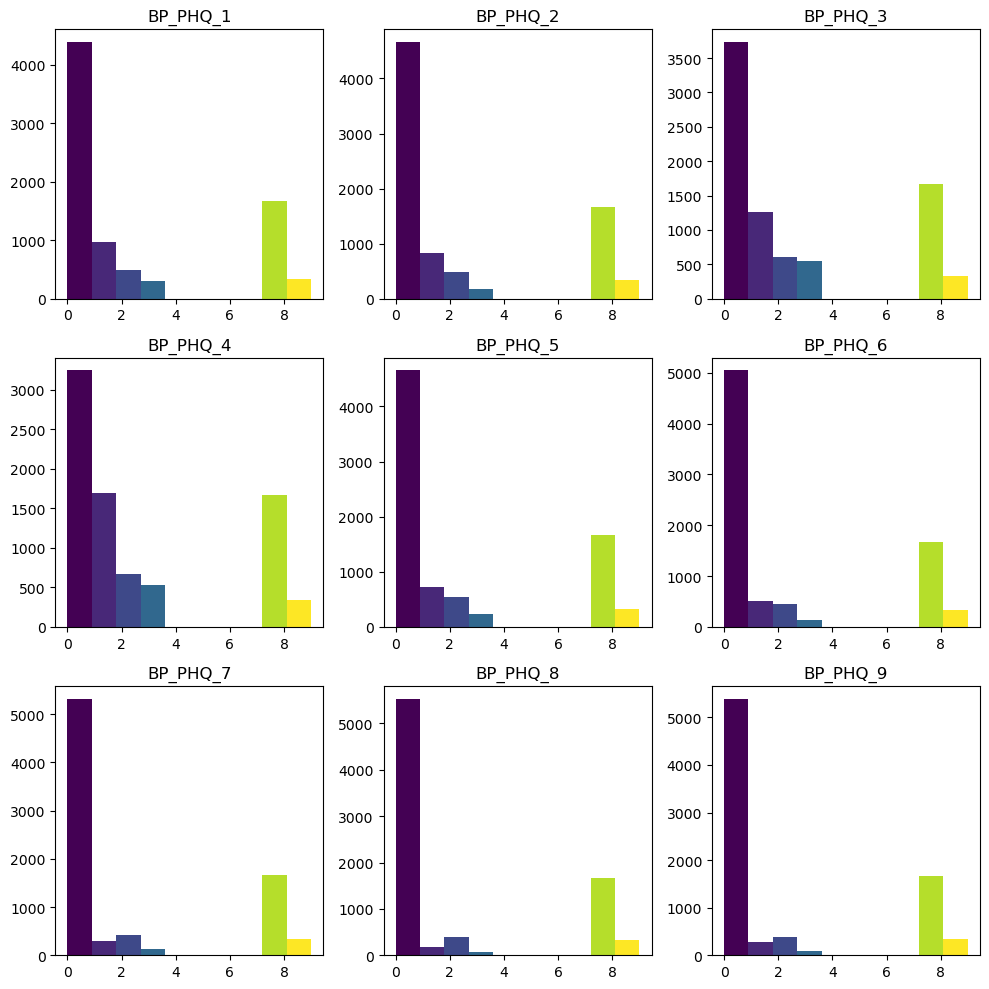

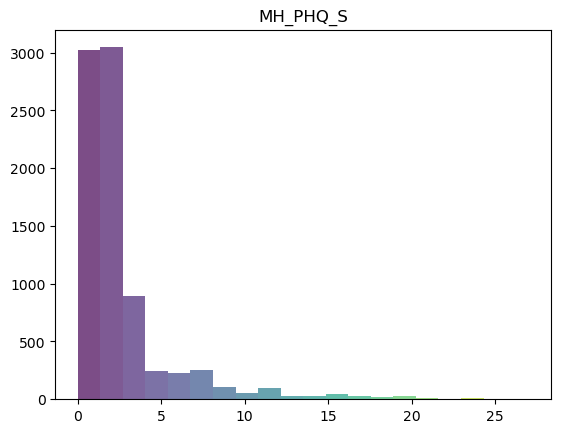

In [15]:
fig, axs = plt.subplots(3, 3 , figsize=(10, 10))
number = 1

for i in range(3):
    for j in range(3):
        n,bins, patches = axs[i, j].hist(all16_df[f"BP_PHQ_{number}"])
        axs[i, j].set_title(f"BP_PHQ_{number}")
        colors = plt.cm.viridis(np.linspace(0, 1, len(patches)))
        # Color each bin differently
        for patch, color in zip(patches, colors):
            patch.set_facecolor(color)

        number += 1
plt.tight_layout()
plt.show()

n,bins, patches = plt.hist(all16_df["MH_PHQ_S"], bins=20, color='blue', alpha=0.7, label="ALL16")

plt.title("MH_PHQ_S")
# Define colors
colors = plt.cm.viridis(np.linspace(0, 1, len(patches)))

for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

plt.show()

From the MH_PHQ_S plot you can see, that in the year 2016 more people have a sum that is 0 and less people have a BP_PHQ_9 of 8 or 9.

Plot the depression levels with feature age from the year 2014

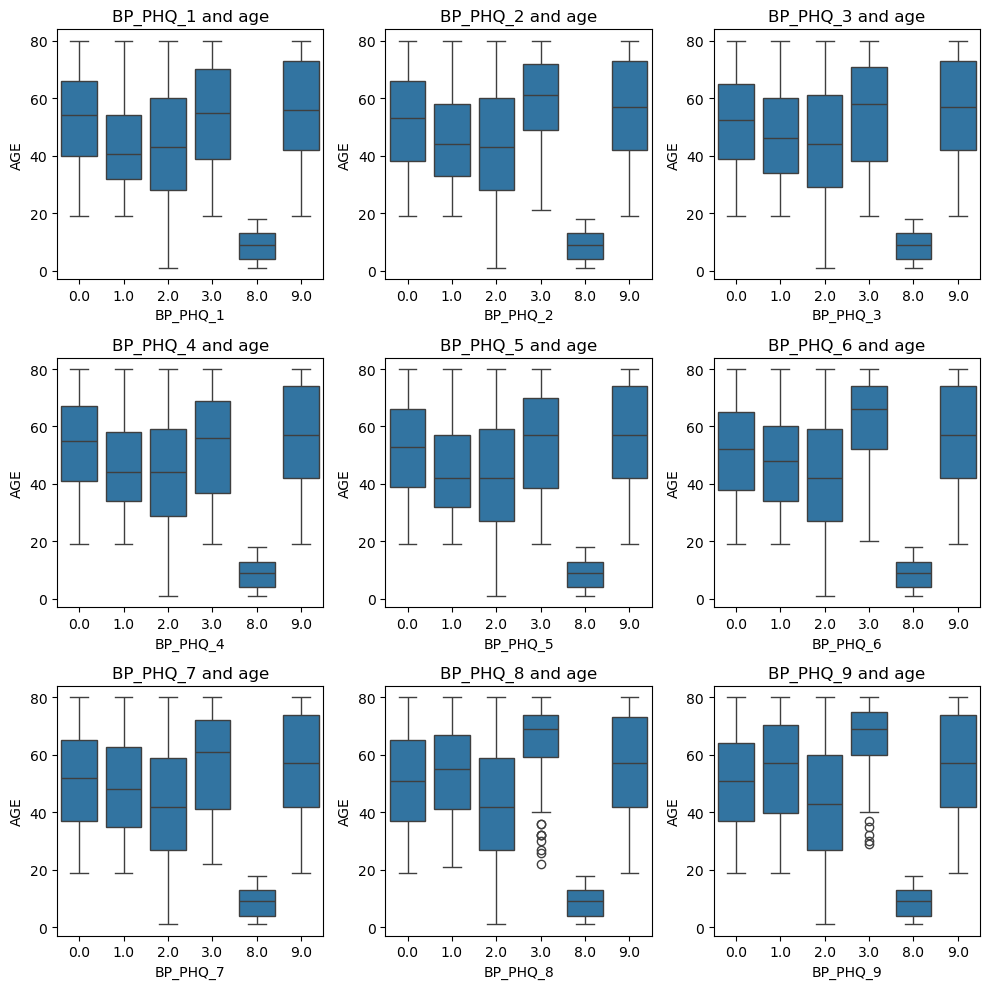

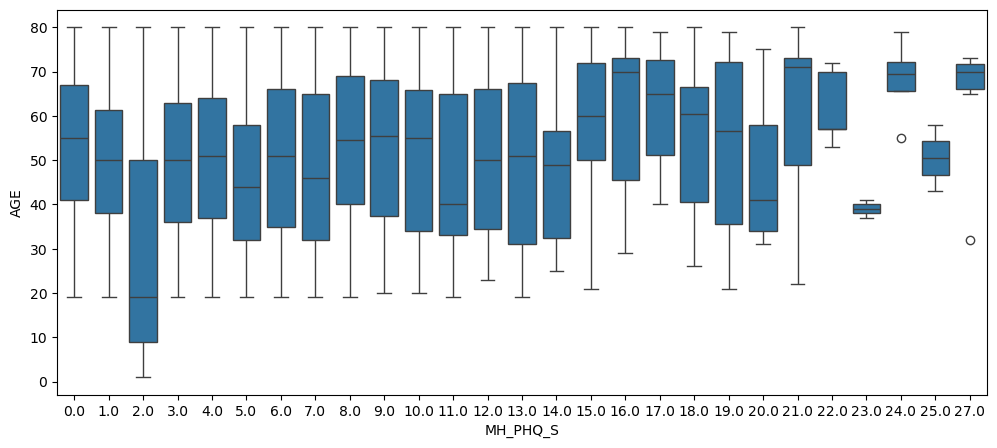

In [16]:
fig, axs = plt.subplots(3, 3 , figsize=(10, 10))
number = 1

for i in range(3):
    for j in range(3):
        sns.boxplot(x = f"BP_PHQ_{number}", y = 'AGE', data=all14_df, ax=axs[i, j])
        axs[i, j].set_title(f"BP_PHQ_{number} and age")
        number += 1

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 5))
sns.boxplot(x = "MH_PHQ_S", y = 'AGE', data=all14_df)
plt.show()

- you can see, that the number 8 in the BP Features as a whole group is a outlier and that is reflected in the MH_PHQ_S plot. Values that are higher than 22 behave like outliers, because of that.
- The sum is well suited for the boxplot where you can cleary see a correlation between the MH_PHQ_S and the increase in age. The median is increasing with the age aswell as the age distribution in the groups

Plot the depression levels with feature age from the year 2016

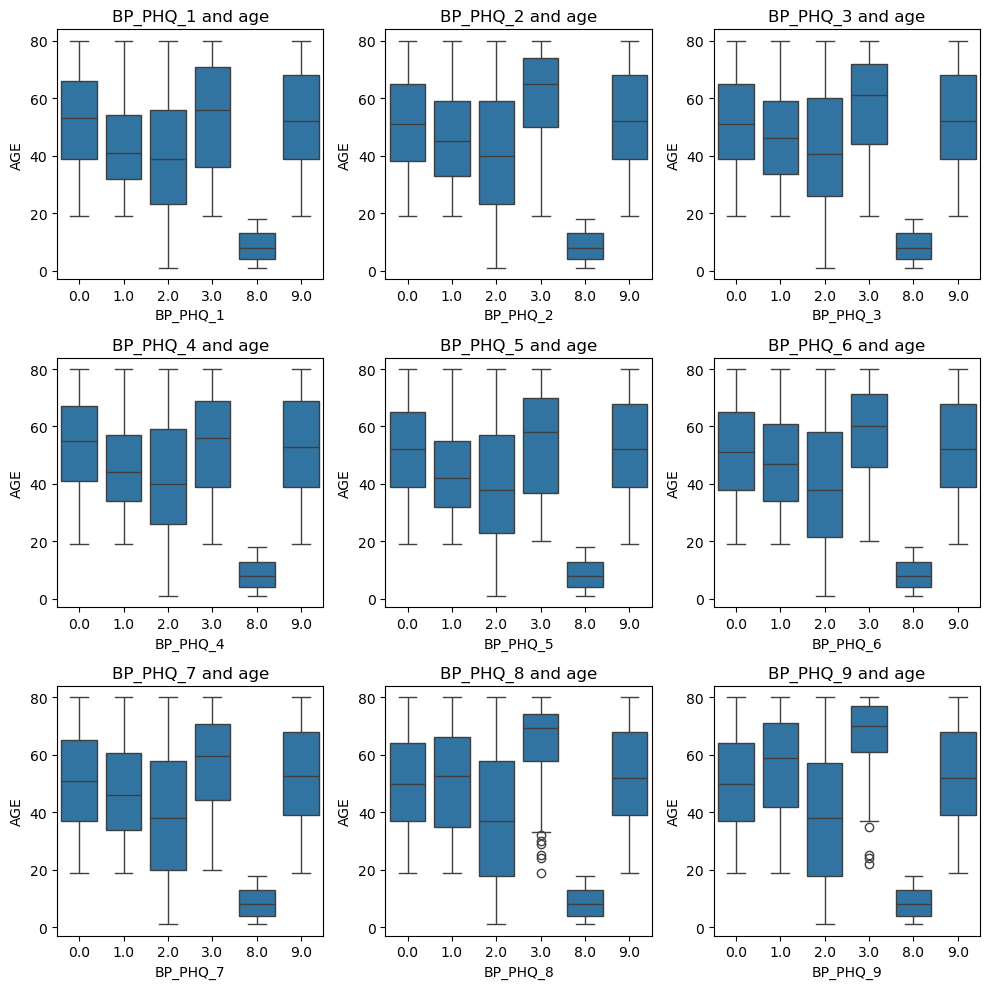

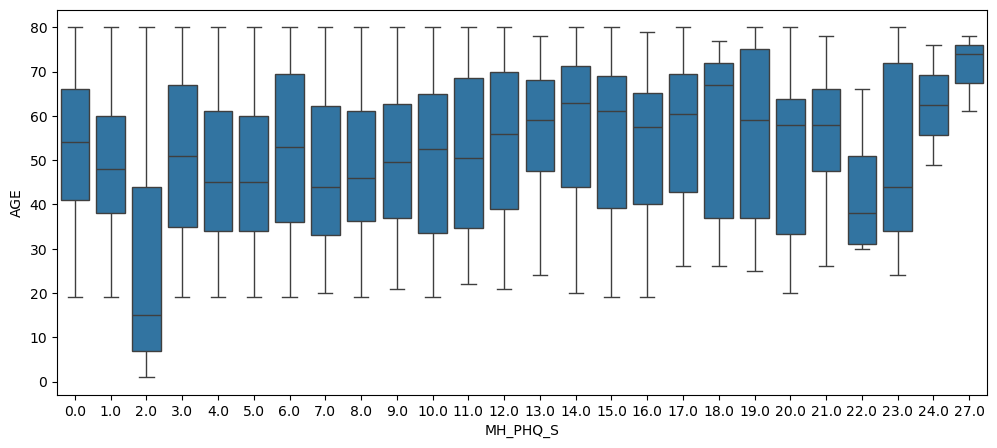

In [17]:
fig, axs = plt.subplots(3, 3 , figsize=(10, 10))
number = 1

for i in range(3):
    for j in range(3):
        sns.boxplot(x = f"BP_PHQ_{number}", y = 'AGE', data=all16_df, ax=axs[i, j])
        axs[i, j].set_title(f"BP_PHQ_{number} and age")
        number += 1

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 5))
sns.boxplot(x = "MH_PHQ_S", y = 'AGE', data=all16_df)
plt.show()

- With the Depression Classifiers 1-9 there are no important things to cover only that when BP_PHQ_x has the value of 8 there is a huge outlier as whole group
- Here the MH_PHQ_S plot has not groups as outliers and there is clearly a correlation between the age and the MH_PHQ_S, because the median of age is increasing with MH_PHQ_S values

Plot the depression features with BMI from the year 2014

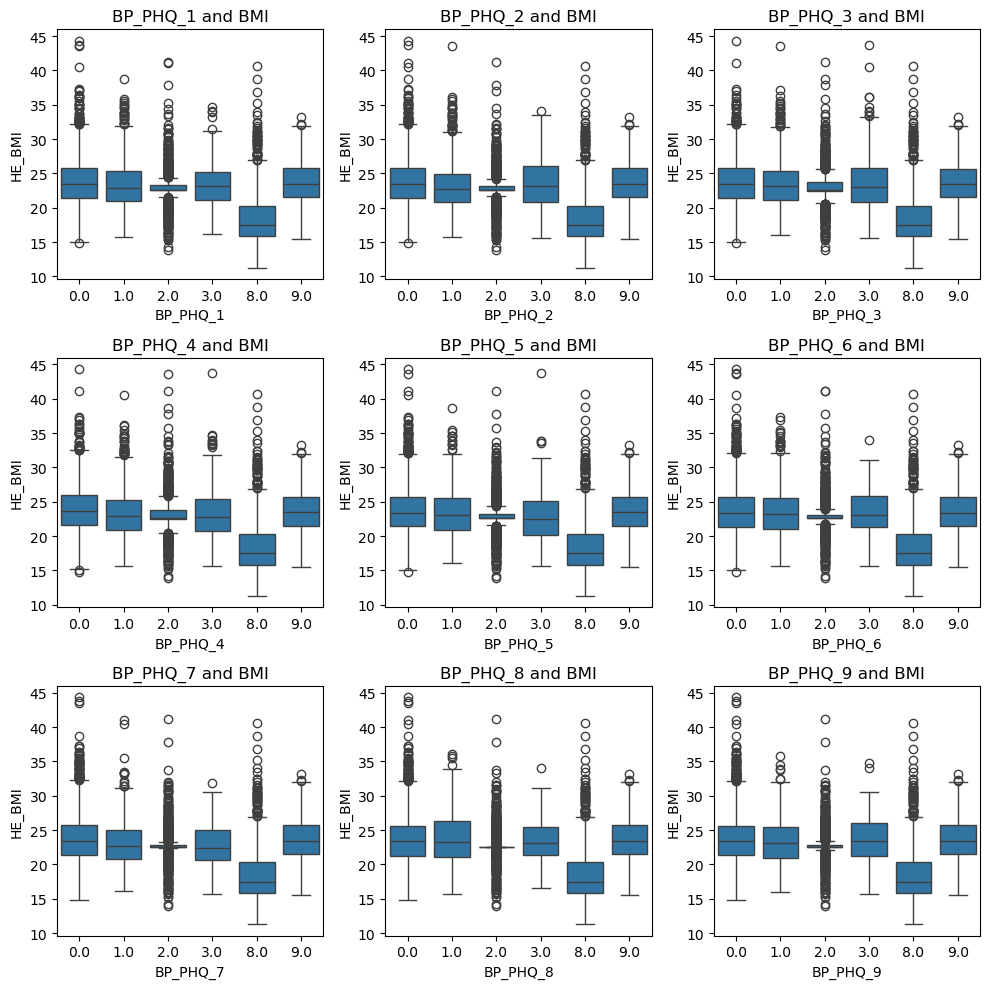

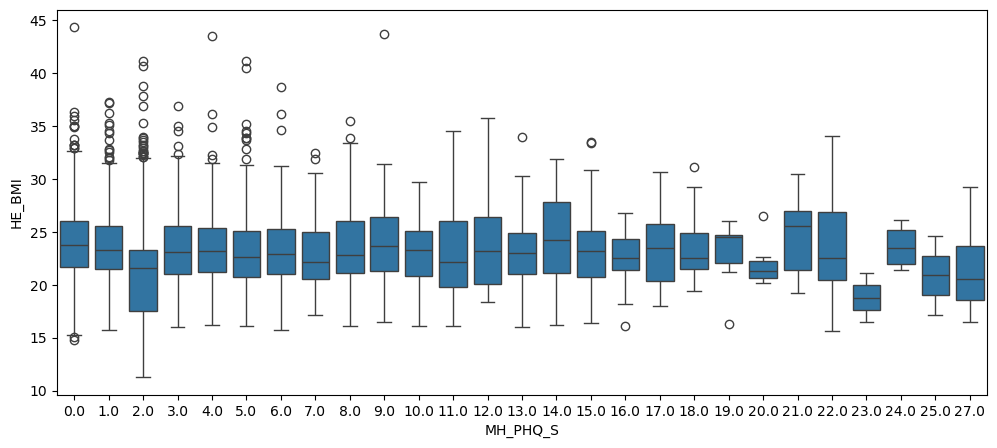

In [18]:
fig, axs = plt.subplots(3, 3 , figsize=(10, 10))
number = 1

for i in range(3):
    for j in range(3):
        sns.boxplot(x = f"BP_PHQ_{number}", y = 'HE_BMI', data=all14_df, ax=axs[i, j])
        axs[i, j].set_title(f"BP_PHQ_{number} and BMI")
        number += 1

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 5))
sns.boxplot(x = "MH_PHQ_S", y = 'HE_BMI', data=all14_df)
plt.show()

Plot the depression features with BMI from the year 2016

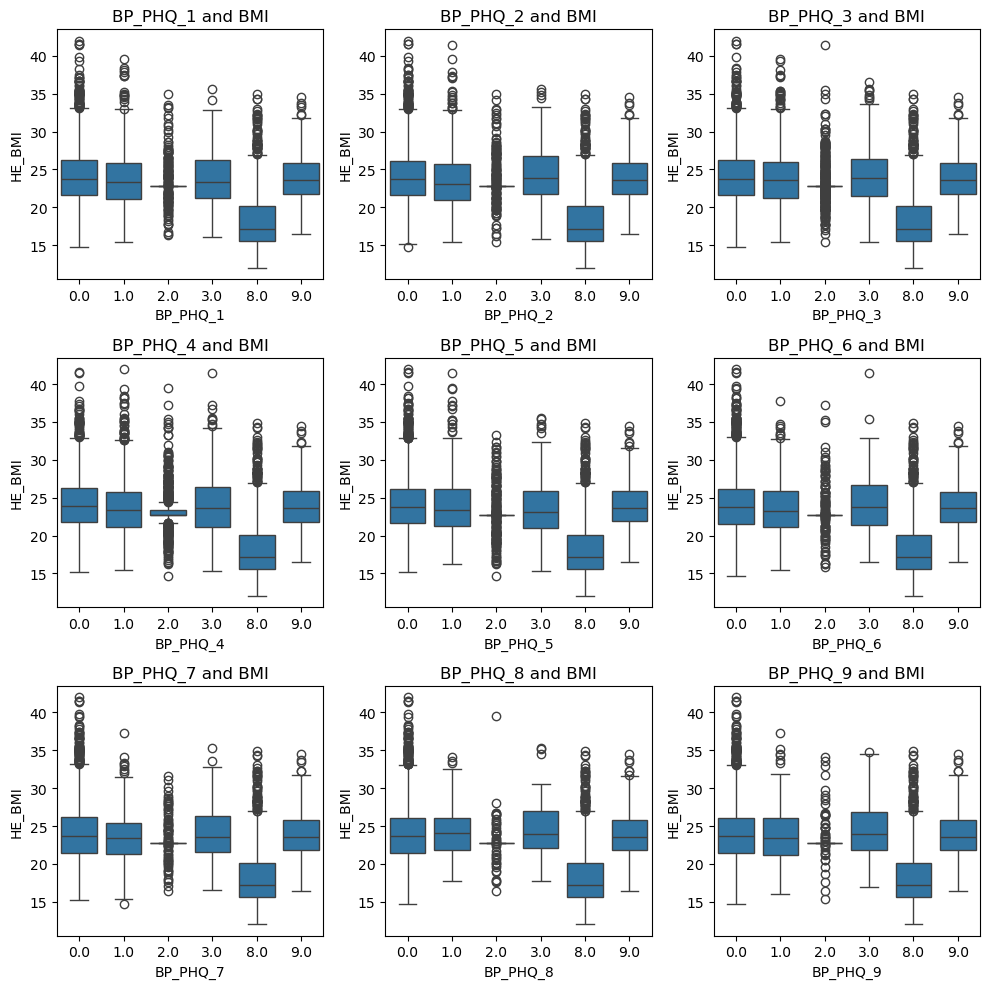

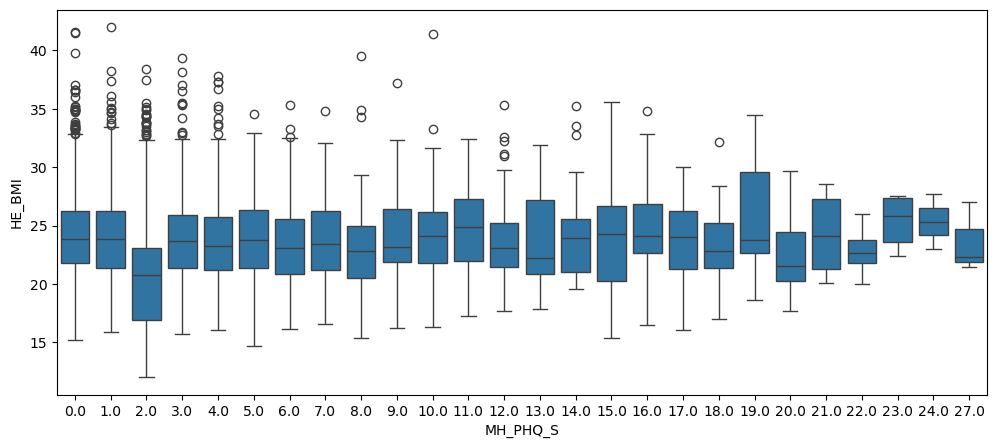

In [19]:
fig, axs = plt.subplots(3, 3 , figsize=(10, 10))
number = 1

for i in range(3):
    for j in range(3):
        sns.boxplot(x = f"BP_PHQ_{number}", y = 'HE_BMI', data=all16_df, ax=axs[i, j])
        axs[i, j].set_title(f"BP_PHQ_{number} and BMI")
        number += 1

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 5))
sns.boxplot(x = "MH_PHQ_S", y = 'HE_BMI', data=all16_df)
plt.show()

- It seems like the BMI has no correlation with the depression classifier

Plot the depression features with EQ5D from the year 2014

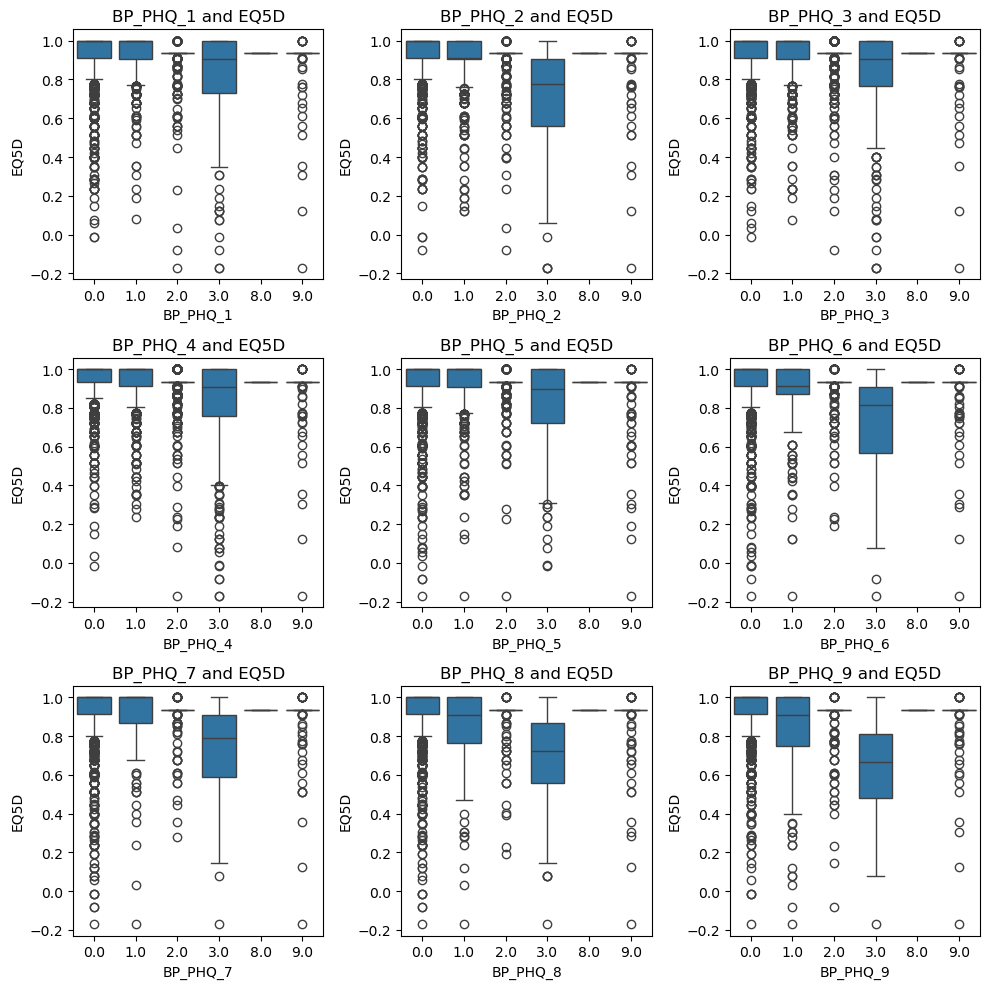

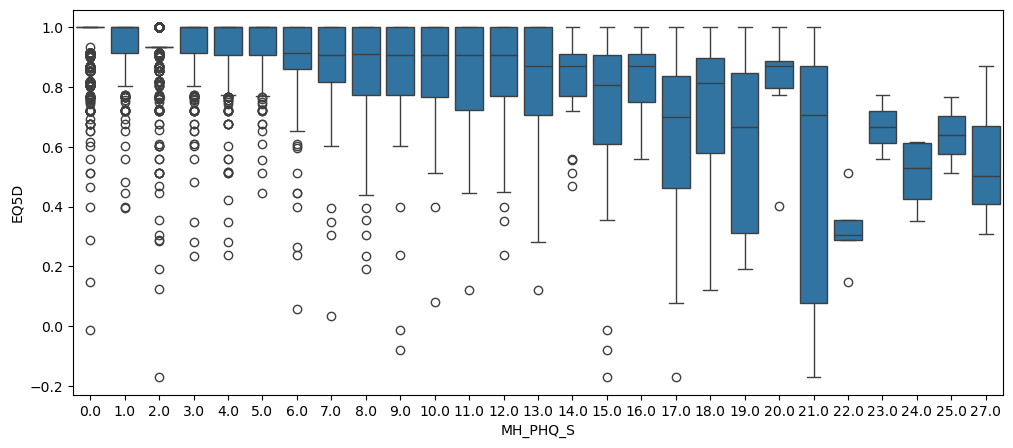

In [20]:
fig, axs = plt.subplots(3, 3 , figsize=(10, 10))
number = 1

for i in range(3):
    for j in range(3):
        sns.boxplot(x = f"BP_PHQ_{number}", y = 'EQ5D', data=all14_df, ax=axs[i, j])
        axs[i, j].set_title(f"BP_PHQ_{number} and EQ5D")
        number += 1

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 5))
sns.boxplot(x = "MH_PHQ_S", y = 'EQ5D', data=all14_df)
plt.show()

Plot the depression features with EQ5D from the year 2016

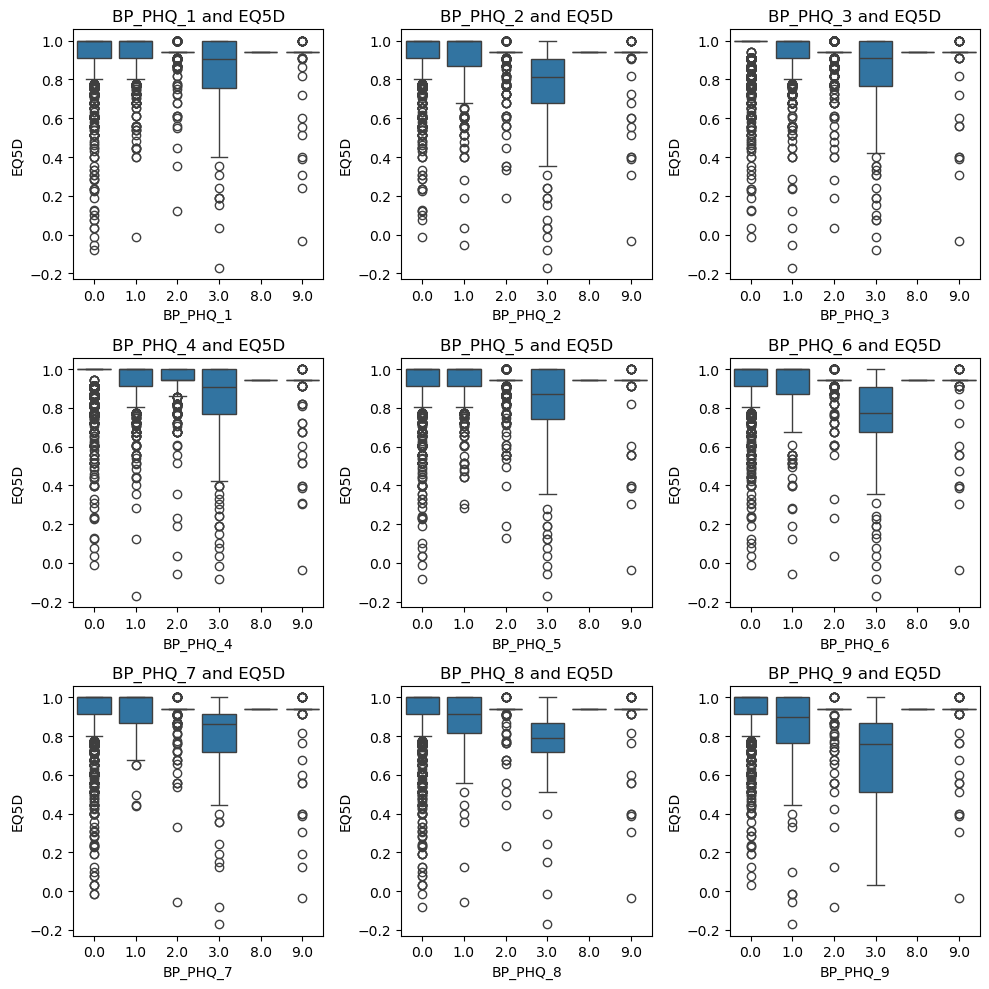

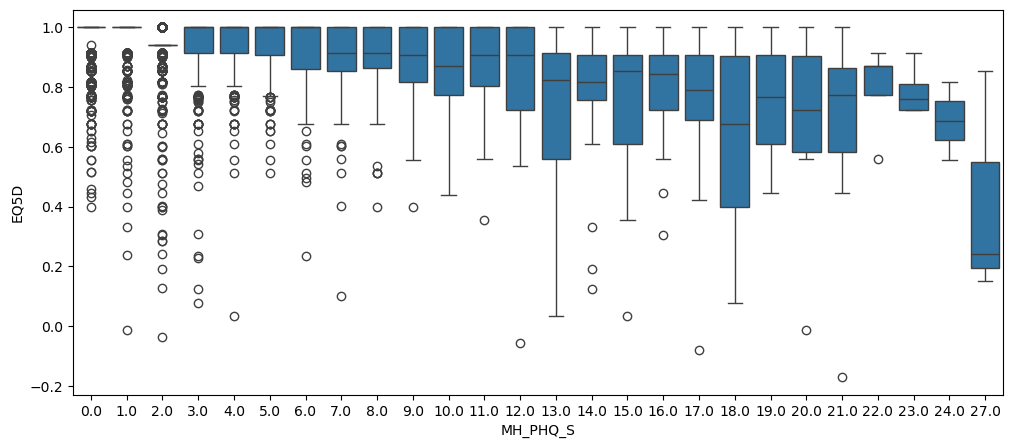

In [21]:
fig, axs = plt.subplots(3, 3 , figsize=(10, 10))
number = 1

for i in range(3):
    for j in range(3):
        sns.boxplot(x = f"BP_PHQ_{number}", y = 'EQ5D', data=all16_df, ax=axs[i, j])
        axs[i, j].set_title(f"BP_PHQ_{number} and EQ5D")
        number += 1

plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 5))
sns.boxplot(x = "MH_PHQ_S", y = 'EQ5D', data=all16_df)
plt.show()

Based on the plot MH_PHQ_S we can see that we have a negative correlation between MH_PHQ_S and the EQ5D, because the plots or median values are moving towards negative values when increasing the MH_PHQ_S

Now use the features bmi and age as a combination to cluster the different depression classifier from the year 2014

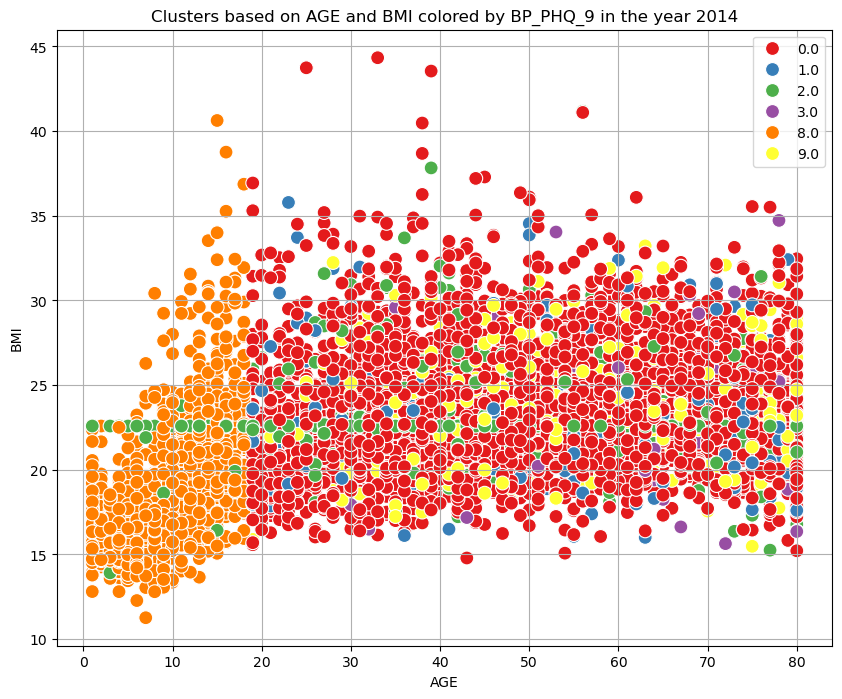

In [22]:
X = all14_df[['AGE', 'HE_BMI']].values

kmeans = KMeans(n_clusters=3, random_state=0)
all14_df['Cluster'] = kmeans.fit_predict(X)

# Plot clusters with different colors based on 'Category'
plt.figure(figsize=(10, 8))
sns.scatterplot(x='AGE', y='HE_BMI', hue='BP_PHQ_9', data=all14_df, palette='Set1', s=100)
plt.title('Clusters based on AGE and BMI colored by BP_PHQ_9 in the year 2014')
plt.xlabel('AGE')
plt.ylabel('BMI')


plt.legend()
plt.grid(True)
plt.show()

Now use the features bmi and age as a combination to cluster the different depression classifier from the year 2016

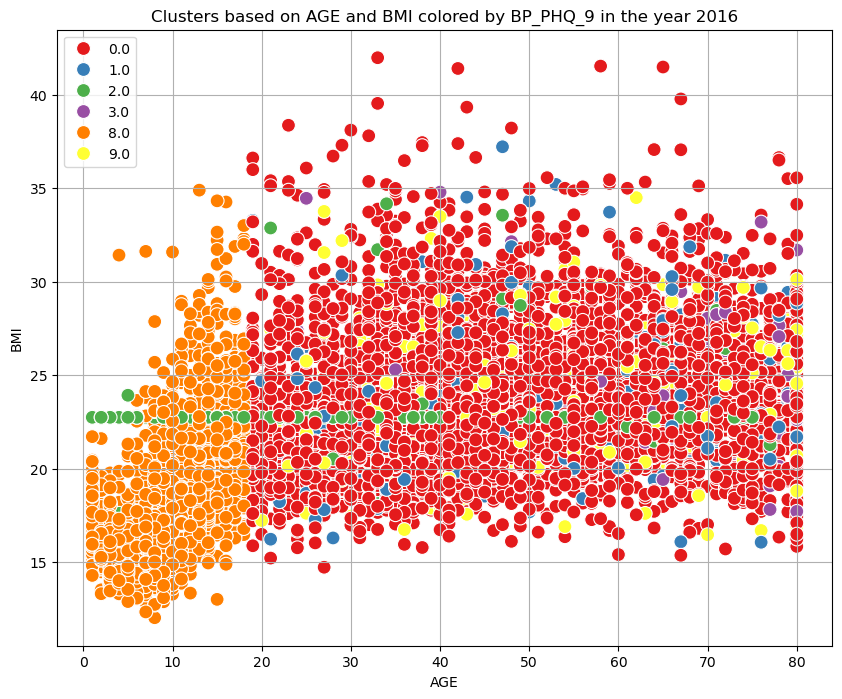

In [23]:
X = all16_df[['AGE', 'HE_BMI']].values

kmeans = KMeans(n_clusters=3, random_state=0)
all16_df['Cluster'] = kmeans.fit_predict(X)

# Plot clusters with different colors based on 'Category'
plt.figure(figsize=(10, 8))
sns.scatterplot(x='AGE', y='HE_BMI', hue='BP_PHQ_9', data=all16_df, palette='Set1', s=100)
plt.title('Clusters based on AGE and BMI colored by BP_PHQ_9 in the year 2016')
plt.xlabel('AGE')
plt.ylabel('BMI')

plt.legend()
plt.grid(True)
plt.show()

In both cluster plots you can clearly see a line that seperates the groups 0 and 8 which means that the age is a important feature